In [180]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
from functools import partial
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

In [181]:
class CUDADataLoader:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for images, labels in self.dataloader:
            yield [images.to('cuda:0'), labels.to('cuda:0')]

    def __len__(self):
        return len(self.dataloader)

    @property
    def dataset(self):
        return self.dataloader.dataset


In [182]:
def MLPClassifier(input_size, output_size, num_neurons, activation_type=nn.Identity, initializer=None):
    layers = [nn.Flatten(1)]
    last_layer_neurons = input_size

    for i, layer_neurons in enumerate(num_neurons):
        layer = nn.Linear(last_layer_neurons, layer_neurons)

        if initializer is not None:
            initializer(layer.weight)

        layers.append(layer)
        layers.append(activation_type())
        last_layer_neurons = layer_neurons

    layers.append(nn.Linear(last_layer_neurons, output_size))
    return nn.Sequential(*layers)


In [183]:
class Swish(nn.Module):
    def __init__(self, beta):
        super(Swish, self).__init__()
        self.beta = beta

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)




In [184]:
# Task 2-b-1 and 2-b-2

class LabelSmoothingLoss(nn.Module):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, logits, targets):
        log_p_x = F.log_softmax(logits, dim=-1)
        loss = -log_p_x.sum(dim=-1).mean()
        nll = F.nll_loss(log_p_x, targets, reduction='mean')
        return ((1-self.epsilon) * nll) + (self.epsilon * loss / logits.size()[-1])

In [185]:
def train(model, dataloader, optimizer, epsilon=None):
    loss_avg = 0.0
    for image_batch, label_batch in dataloader:
        optimizer.zero_grad()
        predictions = model(image_batch)
        loss=None
        if epsilon is None:
            loss = F.cross_entropy(predictions, label_batch)
        else:
            loss = LabelSmoothingLoss(epsilon=epsilon)(predictions, label_batch)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()*image_batch.size(0)

    loss_avg = loss_avg/len(dataloader.dataset)
    return loss_avg

In [186]:
def accuracy(model, dataloader):
    hits = num_batches = 0
    for image_batch, label_batch in dataloader:
        predictions = predict(model, image_batch)
        hits += (predictions == label_batch).count_nonzero()

    return hits / len(dataloader.dataset)


def predict(model, images):
    predictions = model(images)
    predictions = torch.argmax(predictions, dim=1)
    return predictions


In [187]:
# create accuracy plot
def plot_accuracies(accuracies, activation_name):
    plt.figure(figsize=(10, 10))

    for num_additional_layers, conf_accuracies in enumerate(accuracies):
        name = "(50" + ",30"*num_additional_layers+")"
        plt.plot(conf_accuracies, label=name)

    plt.legend()
    plt.title(f"configurations with {activation_name}")
    plt.show()

In [188]:
train_dataset = datasets.CIFAR10(root = "../cifar", train = True, download = False, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "../cifar", train = False, download = False, transform = transforms.ToTensor())

train_dataloader = CUDADataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True))
test_dataloader = CUDADataLoader(DataLoader(test_dataset, batch_size=1_024, pin_memory=True))

In [189]:
make_model_fn = partial(MLPClassifier, input_size=32*32*3, output_size=10,
                        num_neurons=(512, 512), activation_type=partial(Swish, beta=1))

In [190]:
epochs=25
model_sgd = make_model_fn().to('cuda:0')
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.02)
accuracies_without_ls = np.zeros(epochs)
loss_all=[]
accuracies_all=[]

# train model without label-smoothing
loss_list=np.zeros(epochs)
for epoch in range(epochs):
    loss=train(model_sgd, train_dataloader, optimizer_sgd)
    loss_list[epoch]=loss
    accuracies_without_ls[epoch] = accuracy(model_sgd, test_dataloader)
    print(f"epoch = {epoch}, acc_without_label_smoothing={accuracies_without_ls[epoch]:.4f}")

print("---------------------------")
accuracies_all.append(accuracies_without_ls)
loss_all.append(loss_list)

# train model with label-smoothing for different epsilon values
epsilons=[.5,.1,.01,.001]
for epsilon in epsilons:
    train_dataloader = CUDADataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True))
    test_dataloader = CUDADataLoader(DataLoader(test_dataset, batch_size=1_024, pin_memory=True))
    accuracies_with_ls = np.zeros(25)
    loss_list=np.zeros(25)
    for epoch in range(25):
        loss=train(model_sgd, train_dataloader, optimizer_sgd,epsilon=epsilon)
        loss_list[epoch]=loss
        accuracies_with_ls[epoch] = accuracy(model_sgd, test_dataloader)
        print(f"epoch = {epoch}, epsilon = {epsilon}, and accuracies_with_label_smoothing={accuracies_with_ls[epoch]:.4f}")

    print("---------------------------")
    accuracies_all.append(accuracies_with_ls)
    loss_all.append(loss_list)

epoch = 0, acc_without_label_smoothing=0.1984
epoch = 1, acc_without_label_smoothing=0.3427
epoch = 2, acc_without_label_smoothing=0.3520
epoch = 3, acc_without_label_smoothing=0.3421
epoch = 4, acc_without_label_smoothing=0.3939
epoch = 5, acc_without_label_smoothing=0.4017
epoch = 6, acc_without_label_smoothing=0.3837
epoch = 7, acc_without_label_smoothing=0.3836
epoch = 8, acc_without_label_smoothing=0.3566
epoch = 9, acc_without_label_smoothing=0.4502
epoch = 10, acc_without_label_smoothing=0.4242
epoch = 11, acc_without_label_smoothing=0.4331
epoch = 12, acc_without_label_smoothing=0.4256
epoch = 13, acc_without_label_smoothing=0.4497
epoch = 14, acc_without_label_smoothing=0.4697
epoch = 15, acc_without_label_smoothing=0.4234
epoch = 16, acc_without_label_smoothing=0.4750
epoch = 17, acc_without_label_smoothing=0.4117
epoch = 18, acc_without_label_smoothing=0.4768
epoch = 19, acc_without_label_smoothing=0.4383
epoch = 20, acc_without_label_smoothing=0.4611
epoch = 21, acc_without

In [194]:
def plot_loss(loss_all,epsilons):
    plt.figure(figsize=(10,10))
    for index, l in enumerate(loss_all):
        if index==0:
            label="without label-smoothing"
        else:
            label=f"epsilon={epsilons[index-1]}"
        plt.plot(l, label=label)
    plt.title("CIFAR-10 Loss Comparison")
    plt.legend()
    plt.show()

In [195]:
def plot_accuracies(accuracies_all,epsilons):
    plt.figure(figsize=(10,10))
    for index, l in enumerate(accuracies_all):
        if index==0:
            label="without label-smoothing"
        else:
            label=f"epsilon={epsilons[index-1]}"
        plt.plot(l, label=label)
    plt.title("CIFAR-10 Accuracy Comparison")
    plt.legend()
    plt.show()


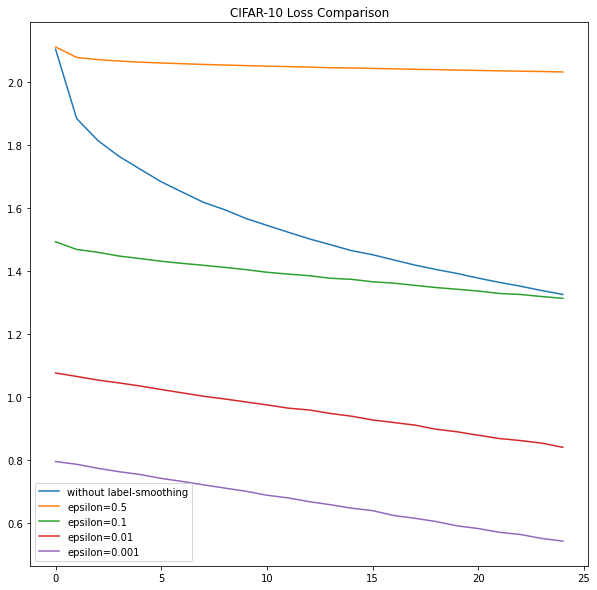

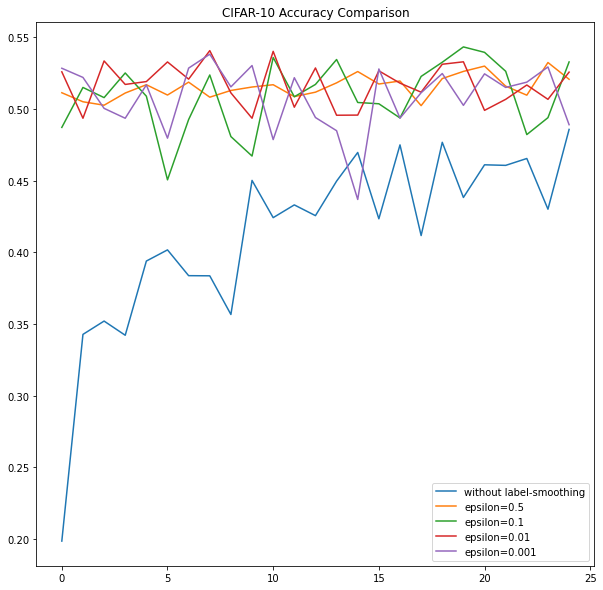

In [196]:
plot_loss(loss_all,epsilons)
plot_accuracies(accuracies_all,epsilons)